In [1]:
import numpy as np
import pandas as pd
import itertools
import math
import scipy.special
import random
import copy

In [2]:
data = pd.read_csv("small.csv")
data.head()

,age,portembarked,fare,numparentschildren,passengerclass,sex,numsiblings,survived
0,1,1,1,1,1,1,1,1
1,2,2,1,1,2,2,1,2
2,1,1,1,1,1,2,1,2
3,2,1,1,1,2,2,1,2
4,2,1,1,1,1,1,1,1


In [3]:
def compute_all_combinations(var,parents,data):
    #var is a dict of size 1 with var as key and list of values it can take as value
    #Parents is a dict with parent names as keys and list of values they can take as values
    
    #Finding the different instances (Xi,Parents(Xi))
    
    values = []
    variables = []
    for elem in var.keys():
        values.append(elem)
        variables.append(var[elem])
    for elem in parents.keys():
        values.append(elem)
        variables.append(parents[elem])
    variables = list(itertools.product(*variables))
    #Computing the M_ijk values and storing them
    #There is maybe a faster time to do this check : https://stackoverflow.com/questions/27654474/count-the-tuples-of-a-pandas-dataframe
    #getting the variable and parents names
    var_name = list(var.keys())[0]
    parent_names = list(parents.keys())
    new_data = data[[var_name] + parent_names]
    new_data.head()
    #transforming the dataframe into a list of tuples
    new_data = list(new_data.itertuples(index=False, name=None))
    count_dict={}
    for var in variables:
        count_dict[var] = 0
    for row in new_data:
        count_dict[row] += 1
    return count_dict
            
            
        
        
    

In [4]:
#Testing
var = {"age":[1,2,3]}
parents = {"sex":[1,2],"survived" : [1,2]}

new_data = compute_all_combinations(var,parents,data)
print(new_data)

{(1, 1, 1): 152, (1, 1, 2): 40, (1, 2, 1): 37, (1, 2, 2): 90, (2, 1, 1): 283, (2, 1, 2): 65, (2, 2, 1): 43, (2, 2, 2): 130, (3, 1, 1): 33, (3, 1, 2): 4, (3, 2, 1): 1, (3, 2, 2): 11}


In [5]:
def compute_fixed_parents(var,parent_values,count_dict):
    #Var is a dict with all of the potential values as a value
    #parent_values is a tuple of fixed parent values
    var_name = list(var.keys())[0]
    new_dict = {}
    for elem in var[var_name]:
        new_dict[elem] = 0
    for key in count_dict.keys():
        #Split the tuple to get the x_value and the parent instantiation
        instantiation = key[1:]
        if instantiation == parent_values:
            new_dict[key[0]] += count_dict[key]
    return new_dict
        
    

In [6]:
count_dict = compute_fixed_parents(var,(1,1),new_data)
print(count_dict)

{1: 152, 2: 283, 3: 33}


In [7]:

def first_sum(var,parent_values,count_dict):
    x_counts = compute_fixed_parents(var,parent_values,count_dict)
    m_ij_0 = sum(x_counts.values())
    internal_sum = 0
    for key in x_counts:
        internal_sum += scipy.special.loggamma(1 + x_counts[key])
    #Finding the value of r_i
    var_name = list(var.keys())[0]
    r_i = len(var[var_name])
    internal_sum += (scipy.special.loggamma(r_i) - scipy.special.loggamma(r_i + m_ij_0))
    
    return internal_sum
    
        

In [8]:
print(first_sum(var,(1,1),new_data))

-406.56753981218185


In [62]:
def sum_over_parents(var,parents,data):
    new_data_counts = compute_all_combinations(var,parents,data)
    parent_values = set()
    #Finding all the parents combinations
    for key in new_data_counts.keys():
        extracted_value = key[1:]
        parent_values.add(extracted_value)
    #Computing the outer-internal sum of the score
    ret_sum = 0
    for instantiation in parent_values:
        ret_sum += first_sum(var,instantiation,new_data_counts)
    return ret_sum
        

        
    

In [87]:
import networkx as nx


class BayesianNetwork:
    
    def __init__(self,variables = [],edges = []):
        self.variables = variables
        self.parents = {}
        self.edges = []
        #Creating a dictionary for storing dependency relationships between variables
        for node in variables:
            self.parents[node] = []
        self.add_edges(edges)
            
    #Adding a dependency
    def add_edge(self,edge):
        self.edges.append(edge)
        self.parents[edge[1]].append(edge[0])
    
    
    def add_edges(self,edges):
        for edge in edges:
            self.edges.append(edge)
            self.parents[edge[1]].append(edge[0])

    #Removing a dependency
    def remove_edge(self,edge):
        if edge[0] in self.parents[edge[1]]:
            self.parents[edge[1]].remove(edge[0])
            self.edges.remove(edge)
    

    #Creating a new Bayesian network

    def copy(self):
        return BayesianNetwork(self.variables,self.edges.copy())
    
    def show_network(self):
        nx_graph = nx.DiGraph()
        nx_graph.add_nodes_from(self.variables)
        nx_graph.add_edges_from(self.edges)
        nx.draw(nx_graph,with_labels = True)
        
    
    def __eq__(self,graph):
        set_1 = set(self.edges)
        set_2 = set(graph.edges)
        return set_1 == set_2
        
            
        
    

In [88]:
def get_variable_values(df):
    return {c: list(df[c].unique()) for c in df.columns}
    

In [89]:
def compute_score(network,data,variable_values):
    score = 0
    for variable in variable_values.keys():
        #On a besoin d'un argument {variable_actuelle : valeurs}
        var_dict = {}
        var_dict[variable] = variable_values[variable]
        #Et d'un autre arguments {parents de la variable : leur valeurs}
        parents_dict = {}
        for parent in network.parents[variable]:
            parents_dict[parent] = variable_values[parent]
        score += sum_over_parents(var_dict,parents_dict,data)
    return score
        
            
        

In [90]:
#Test 
print(get_variable_values(data))

{'age': [1, 2, 3], 'portembarked': [1, 2, 3], 'fare': [1, 2, 3], 'numparentschildren': [1, 2, 3], 'passengerclass': [1, 2, 3], 'sex': [1, 2], 'numsiblings': [1, 2, 3], 'survived': [1, 2]}


In [91]:
variable_values = get_variable_values(data)
network = BayesianNetwork(list(variable_values.keys()),[("age","sex"),("numsiblings","survived")])
print("we here")
compute_score(network,data,variable_values)

we here


-4163.79120315116

In [92]:
def has_cycle(network,added_edge,reverse = False):
    graph = {}
    for elem in network.parents.keys():
        graph[elem] = []
        for elem_2 in network.parents[elem]:
            graph[elem].append(elem_2)
    if reverse: #If reversing the graph, we need to remove the edge from the adjacency list before adding
                #its reverse
        graph[added_edge[0]].remove(added_edge[1])
        graph[added_edge[1]].append(added_edge[0])
    else:
        #If we add an edge
        graph[added_edge[1]].append(added_edge[0])
    visited = set()
    stack = set()
    # DFS function
    def dfs(node):
        visited.add(node)
        stack.add(node)
        if node in graph:
            for parent in graph[node]:
                if parent not in visited:
                    if dfs(parent):
                        return True
                elif parent in stack:
                    return True
        stack.remove(node)
        return False
    # Check for cycles
    for node in graph:
        if node not in visited:
            if dfs(node):
                return True
    return False

def get_new_network(network):
        #Choosing from either deleting an edge or adding one
        i = random.randint(0,2)
        new_network = network.copy()
        #Adding an edge
        u , w = random.randint(0,len(network.variables) - 1),random.randint(0,len(network.variables) - 1)
        if i == 0 or (len(network.edges) == 0):
            simple_digraph = False
            while(True):
                u , w = random.randint(0,len(network.variables) - 1),random.randint(0,len(network.variables) - 1)
                #Checking if it's a new edge
                if (network.variables[u] not in network.parents[network.variables[w]]):
                    #Checking if it's not a loop and that it does not create a cycle
                    if ((u != w) and not(has_cycle(network,(network.variables[u],network.variables[w])))):
                        new_network.add_edge((network.variables[u],network.variables[w]))
                        break
        #Deleting an edge
        elif i == 1:
            while(network.variables[u] not in network.parents[network.variables[w]]):
                u , w = random.randint(0,len(network.variables) - 1),random.randint(0,len(network.variables) - 1)
            new_network.remove_edge((network.variables[u],network.variables[w]))
        #Reversing an edge
        else:
            visited = set()
            #Choosing a random edge to reverse
            while(True):
                if len(visited) == len(network.edges):
                    return network
                i = random.randint(0,len(network.edges)-1)
                var_1,var_2 = network.edges[i]
                if (var_1,var_2) in visited:
                    continue
                visited.add((var_1,var_2))
                #Checking if reversing an edge does not create a cycle
                if not(has_cycle(network,(var_2,var_1),reverse = True)):
                    new_network.remove_edge(network.edges[i])
                    new_network.add_edge((var_2,var_1))
                    break
        return new_network
            
                

In [93]:
new_network = get_new_network(network)

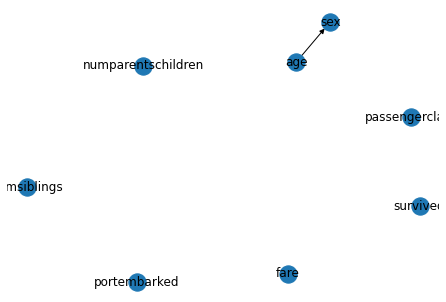

In [94]:
new_network.show_network()

In [95]:
compute_score(new_network,data,variable_values)

-4167.3133047217725

In [103]:
def acceptance_probability(old_score, new_score, temperature):
    if new_score > old_score:
        return 1.0
    else:
        return np.exp((new_score - old_score) / temperature)


def bn_simulated_annealing(data,init_network,temperature = 1000,cooling_rate = 0.95,max_iterations = 1000):
    variable_values = get_variable_values(data)
    current_network = init_network.copy()
    current_score = compute_score(current_network,data,variable_values)
    print(current_score)
    visited_graphs = set()
    for i in range(max_iterations):
        if (i % 10 == 0):
            #print("iteration",i)
            pass
        new_network = get_new_network(current_network)
        new_score = compute_score(new_network,data,variable_values)
        
        prob = acceptance_probability(current_score, new_score, temperature)
        rand = np.random.rand()
        if  rand < prob:
            current_network = new_network
            current_score = new_score
            #print(current_score)
        temperature *= cooling_rate
    print("optimal network score",current_score)
    return current_network
    

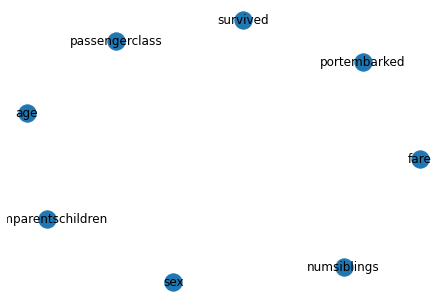

In [104]:
other_network = BayesianNetwork(variables = list(variable_values.keys()))
other_network.show_network()

In [105]:
optimal_network = bn_simulated_annealing(data, other_network)

-4166.225858784904
optimal network score -3794.8555977097963



[df2onehot] >Auto detecting dtypes.


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 140.56it/s]


[df2onehot] >Set dtypes in dataframe..


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 286.01it/s]

[df2onehot] >Total onehot features: 20
[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]


[bnlearn] >Compute structure scores ['k2', 'bds', 'bic', 'bdeu'] for model comparison (higher is better).
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


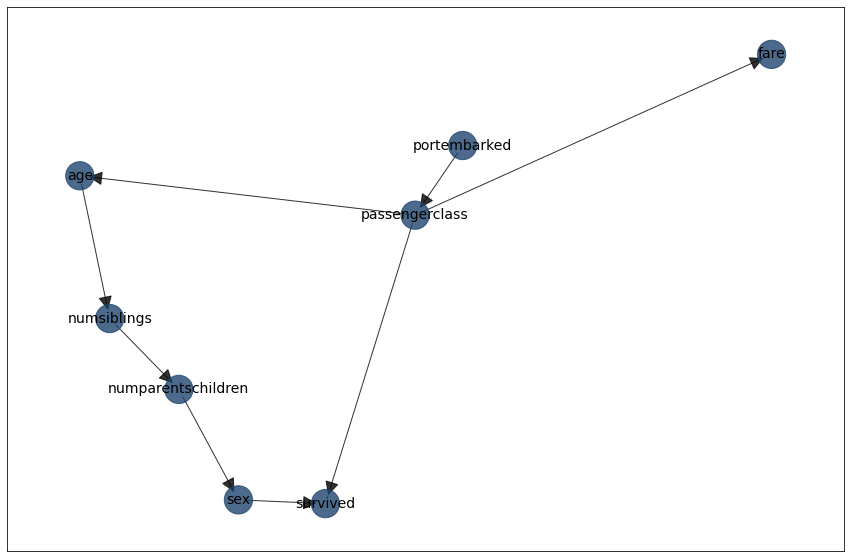

In [106]:
import bnlearn as bn

# Load dataframe
# Pre-processing of the input dataset
dfhot, dfnum = bn.df2onehot(data)

# Structure learning
DAG = bn.structure_learning.fit(dfnum)

# Plot
G = bn.plot(DAG)

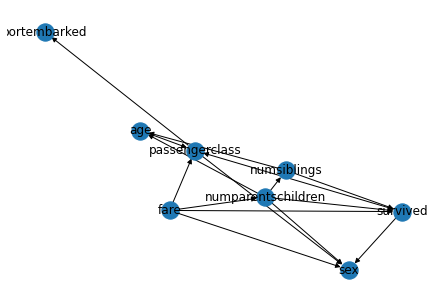

In [102]:
optimal_network.show_network()

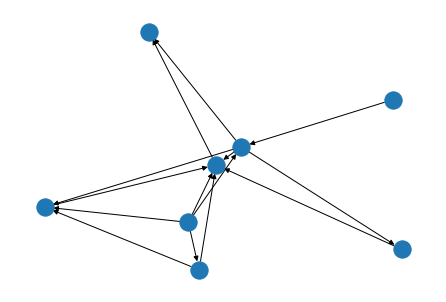

In [86]:
optimal_network.show_network()